In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.driver.memory": "4g",
        "spark.executor.memory": "4g",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1716515774201_0004,pyspark,idle,Link,Link,


In [2]:
from pyspark.sql.functions import col, min, sum, avg, max

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1716515774201_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("seaborn==0.10.1", "https://pypi.org/simple")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cach

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
def load_data(file_name):
    """ Load data from CSV file on S3 using Spark """
    s3_path = f"s3a://kz-final-project/{file_name}"
    return spark.read.csv(s3_path, header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
def load_student_performance_data(log_problem_df, info_user_data_df, info_content_df):
    """ Load and merge student exercise performance data """
    return log_problem_df.join(info_user_data_df, 'uuid').join(info_content_df, 'ucid')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def ensure_score_column(df):
    """ Ensure the 'score' column is added """
    return df.withColumn('score', col('is_correct').cast('int'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def ensure_user_grade_column(df):
    """ Ensure the 'user_grade' column is available """
    return df.withColumn('user_grade', col('user_grade'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def analyze_performance_by_grade(df):
    """ Analyze performance by student grade """
    return df.groupBy('user_grade').agg(
        avg(col('score')).alias('average_score'),
        max(col('score')).alias('max_score'),
        min(col('score')).alias('min_score')
    ).orderBy('user_grade')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def analyze_performance_by_gender(df):
    """ Analyze performance by gender """
    return df.groupBy('gender').agg(
        avg('score').alias('average_score')
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
def analyze_performance_by_city(df):
    """ Analyze performance by city """
    return df.groupBy('user_city').agg(
        avg(col('score')).alias('average_score'),
        max(col('score')).alias('max_score'),
        min(col('score')).alias('min_score')
    ).orderBy('user_city')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def ensure_aggregation_columns(df):
    """ Ensure the correct data types for aggregation columns """
    return df.withColumn('total_sec_taken', col('total_sec_taken').cast('double')) \
             .withColumn('used_hint_cnt', col('used_hint_cnt').cast('int')) \
             .withColumn('total_attempt_cnt', col('total_attempt_cnt').cast('int'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
def analyze_engagement_scores(df):
    """ Analyze engagement and scores """
    return df.groupBy('uuid').agg(
        avg('total_sec_taken').alias('avg_time_spent'),
        avg('score').alias('average_score'),
        sum('used_hint_cnt').alias('total_hints_used'),
        sum('total_attempt_cnt').alias('total_attempts')
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
def analyze_performance_by_coach(df):
    """ Analyze the performance and engagement of self-taught and non-self-taught students """
    df = df.withColumn('avg_hints_per_attempt', col('used_hint_cnt') / col('total_attempt_cnt'))
    return df.groupBy('is_self_coach').agg(
        avg('score').alias('average_score'),
        avg('total_sec_taken').alias('avg_time_spent'),
        avg('avg_hints_per_attempt').alias('avg_hints_per_attempt')
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Load data
info_content_df = load_data('Info_Content.csv')
info_user_data_df = load_data('Info_UserData.csv')
log_problem_df = load_data('Log_Problem.csv')

# Load and process student performance data
student_performance = load_student_performance_data(log_problem_df, info_user_data_df, info_content_df)
student_performance = ensure_score_column(student_performance)
student_performance = ensure_user_grade_column(student_performance)

# Analyze data
performance_by_grade = analyze_performance_by_grade(student_performance)
performance_by_gender = analyze_performance_by_gender(student_performance)
performance_by_city = analyze_performance_by_city(student_performance)

# Display results
performance_by_grade.show(10)
performance_by_gender.show(10)
performance_by_city.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+---------+---------+
|user_grade|     average_score|max_score|min_score|
+----------+------------------+---------+---------+
|         1|0.7794948202199258|        1|        0|
|         2|0.7485471272936751|        1|        0|
|         3|0.7497257938039108|        1|        0|
|         4|0.7371591570254749|        1|        0|
|         5|0.7136067128402784|        1|        0|
|         6|0.6859273166003635|        1|        0|
|         7|0.6842689338608399|        1|        0|
|         8|0.6276601398703926|        1|        0|
|         9| 0.624073324184092|        1|        0|
|        10|   0.6246006603307|        1|        0|
+----------+------------------+---------+---------+
only showing top 10 rows

+-----------+------------------+
|     gender|     average_score|
+-----------+------------------+
|       null|0.6863409096148999|
|       male|0.7137804515611136|
|     female|0.7139499181073535|
|unspecified|0.7021105730098192|
+-----------+--

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

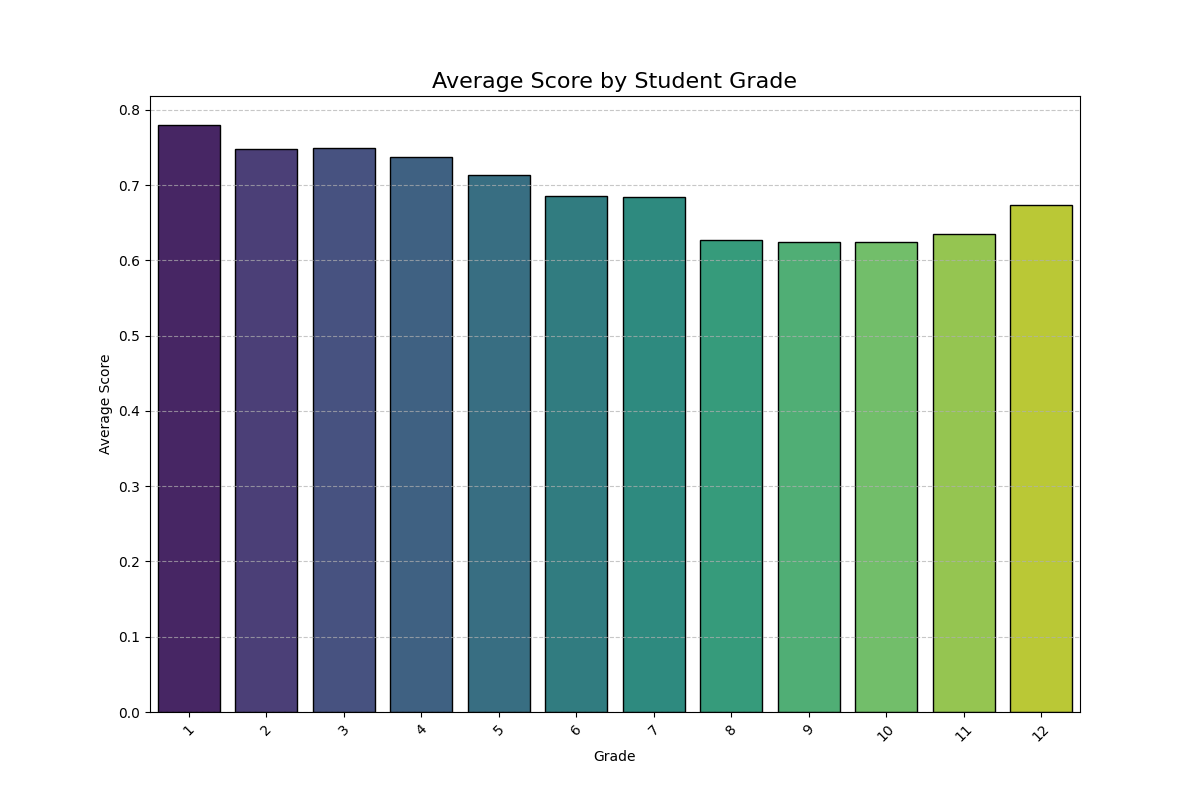

In [19]:
# Plot the average score by student grade
performance_by_grade_pd = performance_by_grade.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='user_grade', y='average_score', data=performance_by_grade_pd, palette='viridis', edgecolor='black')
plt.title('Average Score by Student Grade', fontsize = 16)
plt.xlabel('Grade')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

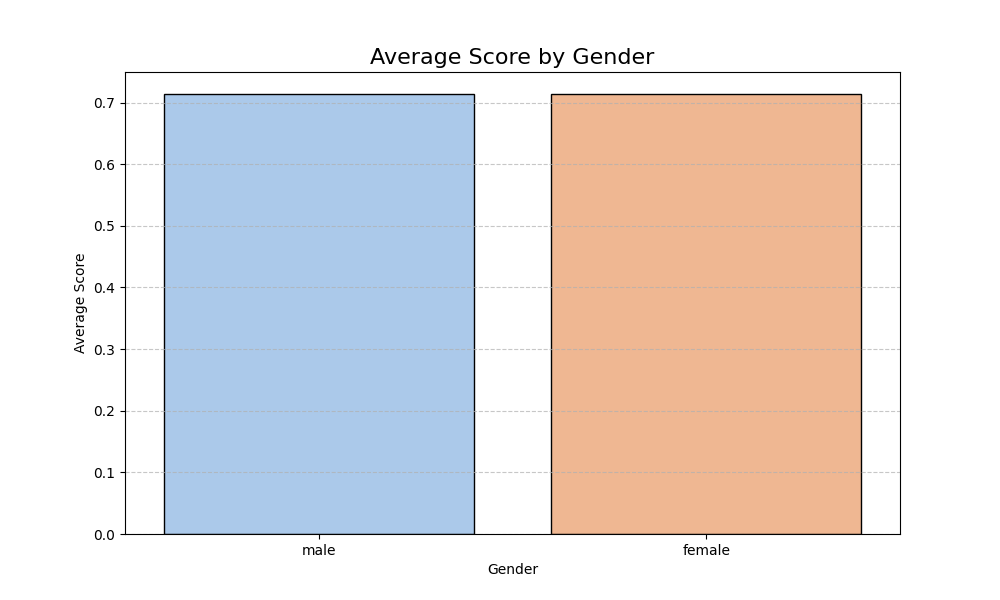

In [20]:
# Filter the DataFrame to only include male and female
filtered_gender_df = performance_by_gender.filter(performance_by_gender['gender'].isin(['male', 'female']))

# Plot the average score by gender
performance_by_gender_pd = filtered_gender_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='average_score', data=performance_by_gender_pd, palette='pastel', edgecolor='black')
plt.title('Average Score by Gender', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

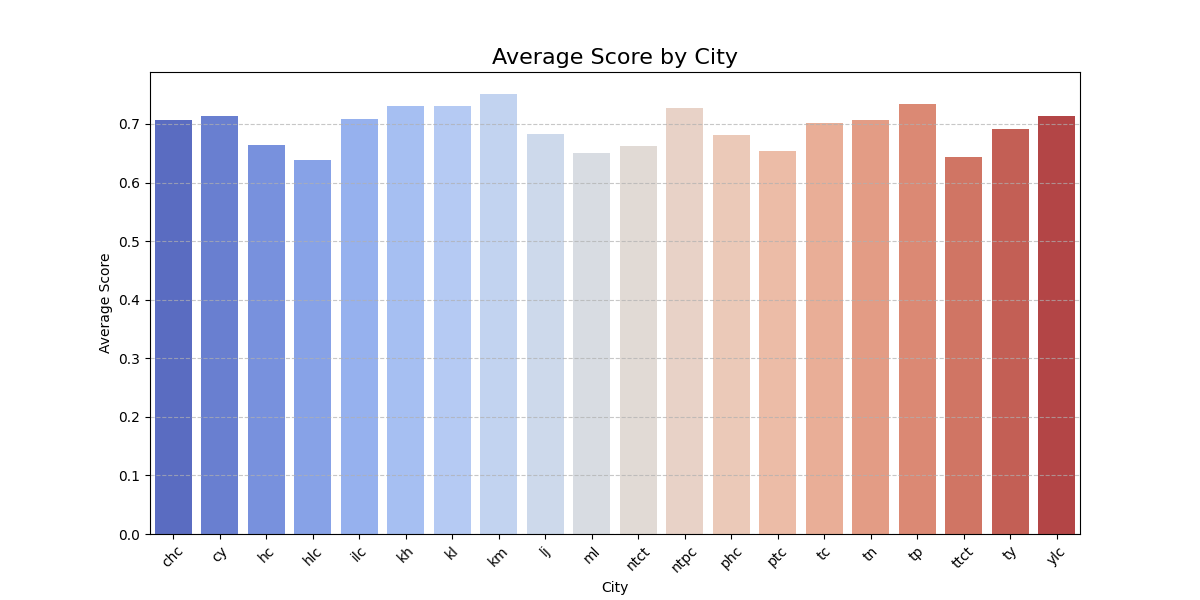

In [21]:
# Plot the average score by city
performance_by_city_pd = performance_by_city.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='user_city', y='average_score', data=performance_by_city_pd, palette='coolwarm')
plt.title('Average Score by City', fontsize=16)
plt.xlabel('City')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

In [22]:
# Ensure the correct data types for aggregation columns
student_performance = ensure_aggregation_columns(student_performance)

# Analyze engagement and scores
engagement_scores = analyze_engagement_scores(student_performance)
engagement_scores.show(10)

# Analyze performance by coach
performance_by_coach = analyze_performance_by_coach(student_performance)
performance_by_coach.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+------------------+----------------+--------------+
|                uuid|    avg_time_spent|     average_score|total_hints_used|total_attempts|
+--------------------+------------------+------------------+----------------+--------------+
|XzjV7d232DDbc3fwZ...|38.890075376884425| 0.867462311557789|             535|          1870|
|Ad/lLtZjApoQ7GhaI...| 39.01439645625692|0.4429678848283499|            1441|          2933|
|e+ritEYXMn9OE97kj...|  81.4888888888889|0.7973856209150327|             320|          1395|
|J/lfDuHE1gTsNBk/r...| 64.64321608040201|0.7738693467336684|              53|           275|
|0r0JQhzLmXSnXQy/O...| 43.39154411764706|0.7297794117647058|             381|          1067|
|WW+i8hVRURizh3yad...|103.28641975308642|0.7530864197530864|             106|           611|
|cXpVxuFVbcITI4mcw...| 67.34699714013347|0.7159199237368923|             300|          1458|
|zr+bafKBCxuS4QqLC...|29.633079847908746|0.7889733840304183|          

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

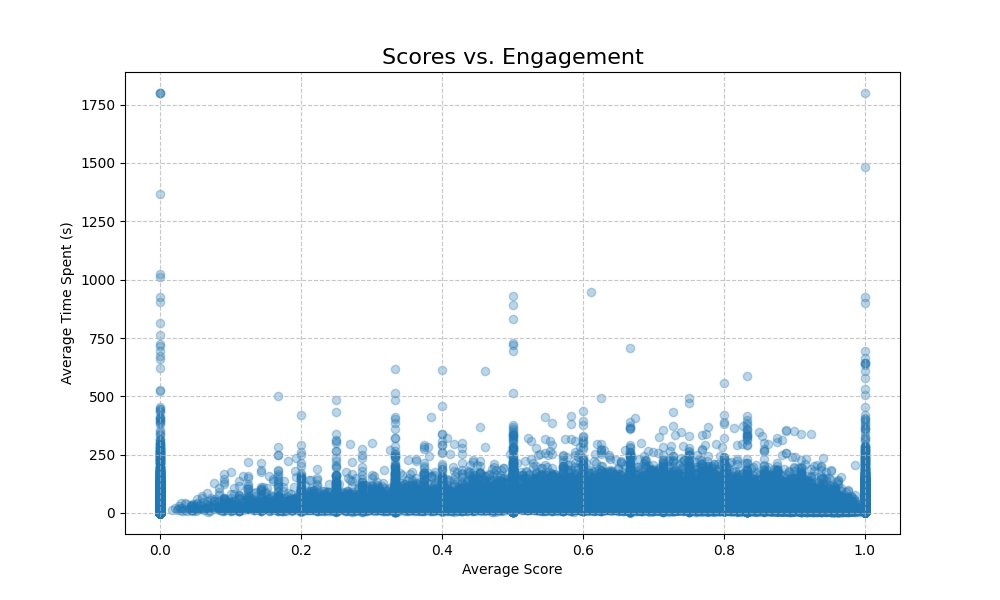

In [23]:
# Plot the relationship between average time spent and average score
engagement_data = engagement_scores.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['avg_time_spent'], alpha=0.3)
plt.title('Scores vs. Engagement', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Average Time Spent (s)')
plt.grid(True, linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

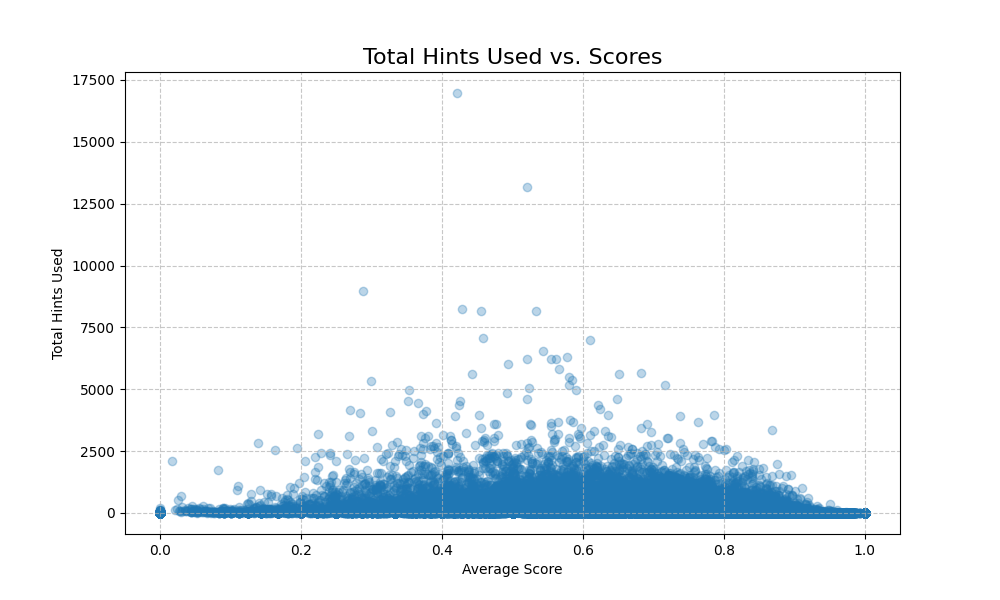

In [24]:
# Plot the relationship between total hints used and average score
plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['total_hints_used'], alpha=0.3)
plt.title('Total Hints Used vs. Scores', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Total Hints Used')
plt.grid(True, linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

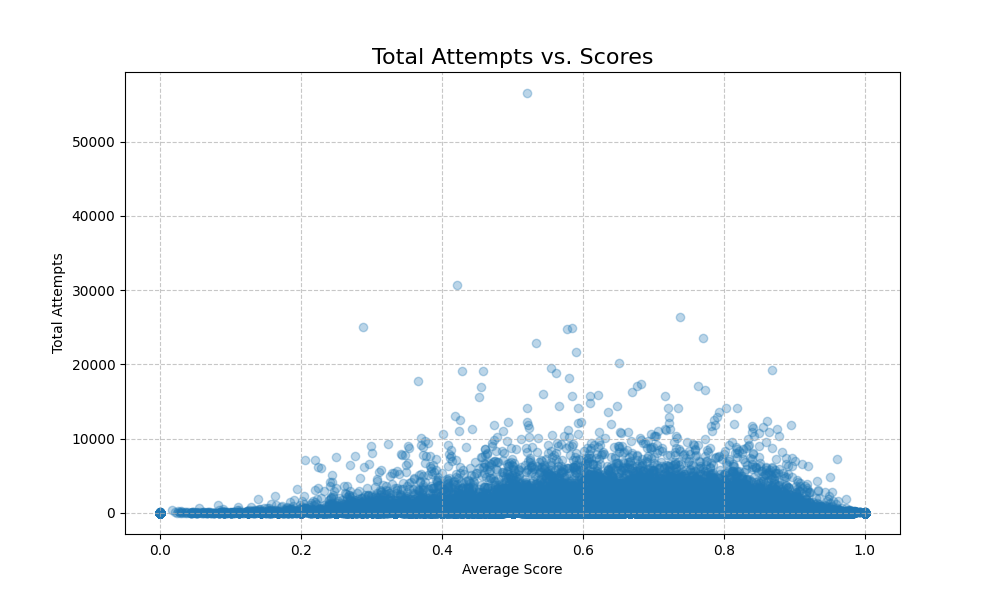

In [26]:
# Plot the relationship between total attempts and average score
plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['total_attempts'], alpha=0.3)
plt.title('Total Attempts vs. Scores', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Total Attempts')
plt.grid(True, linestyle='--', alpha=0.7)

%matplot plt

In [27]:
# Convert the dataframe and set labels for the plots
performance_by_coach_pd = performance_by_coach.toPandas()

labels = ['Self-Coach', 'Non-Self-Coach']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

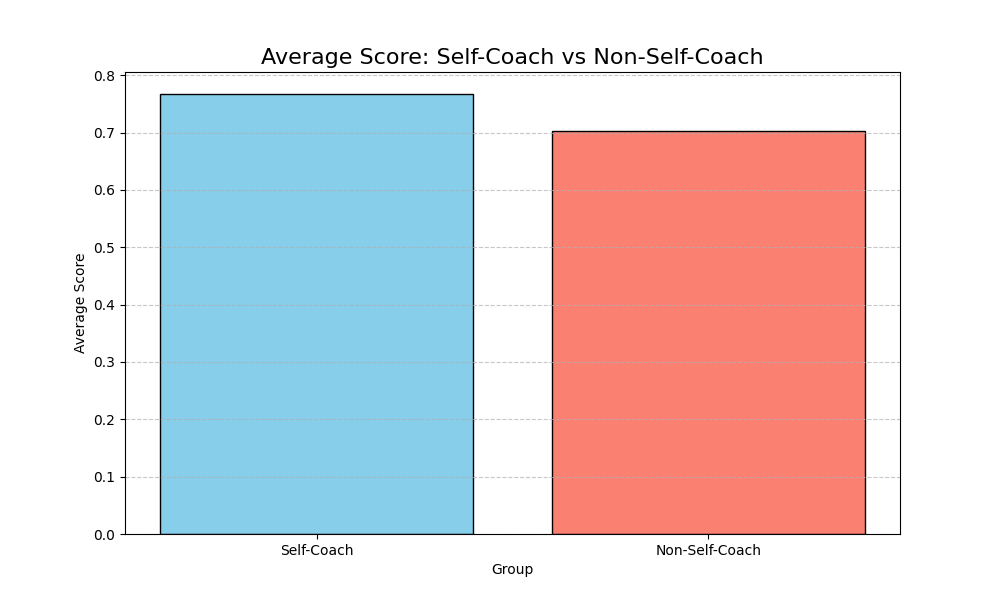

In [28]:
# Plot a bar chart of average scores
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_by_coach_pd['average_score'], color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Score')
plt.title('Average Score: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

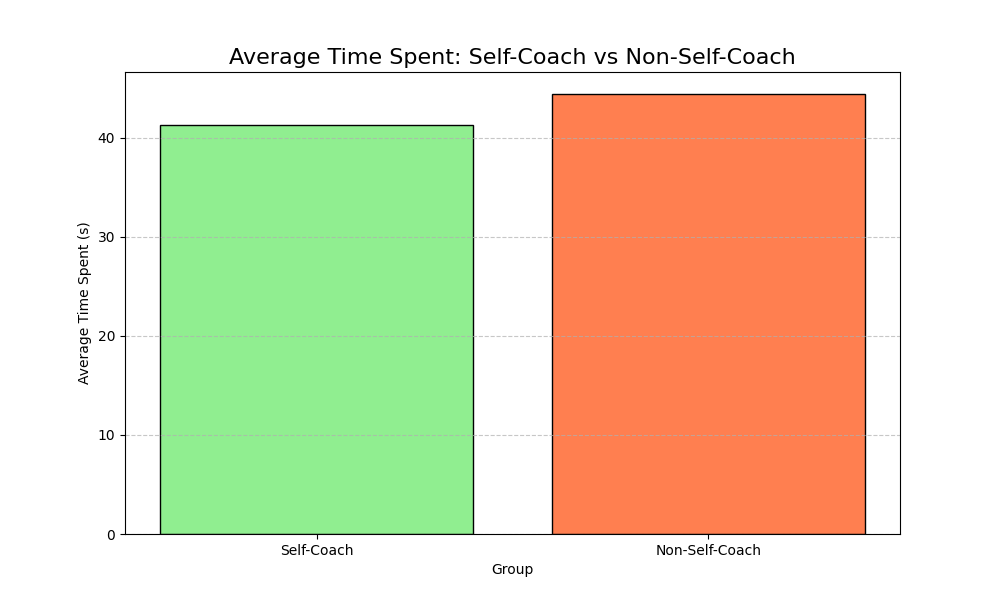

In [29]:
# Plot a bar chart of average time spent
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_by_coach_pd['avg_time_spent'], color=['lightgreen', 'coral'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Time Spent (s)')
plt.title('Average Time Spent: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

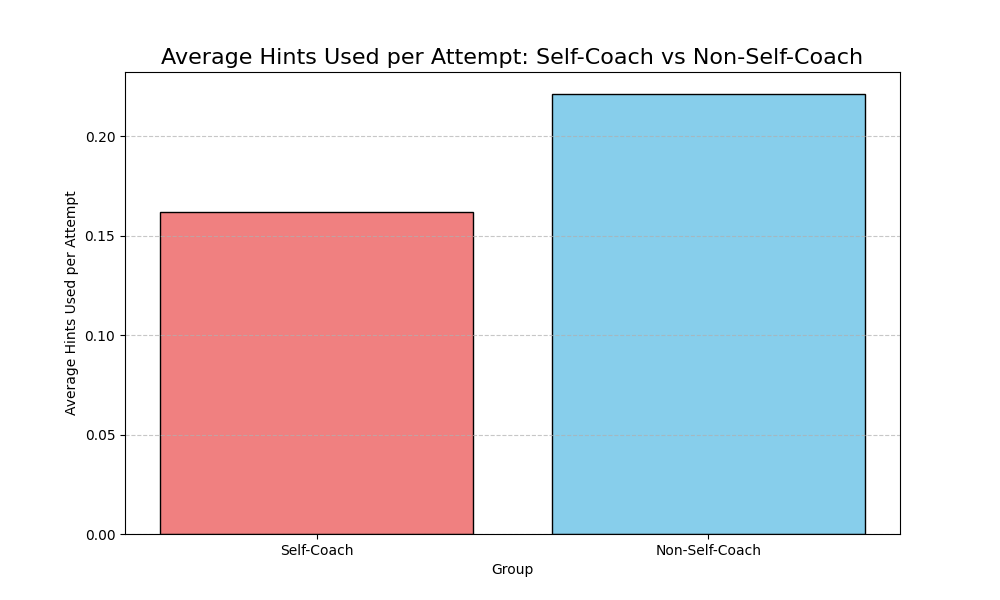

In [30]:
# Plot a bar chart of the total number of hints used
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_by_coach_pd['avg_hints_per_attempt'], color=['lightcoral', 'skyblue'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Hints Used per Attempt')
plt.title('Average Hints Used per Attempt: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

%matplot plt

In [31]:
# Save processed data to S3
student_performance.write.parquet("s3://kz-final-project/student_performance/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…